In [2]:
# standard
import pandas as pd
import numpy as np
import random
import os
import math

from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection  import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, mean_squared_error, mean_absolute_error

# plots and images
import seaborn as sns
import matplotlib.pyplot as plt
from IPython.display import Image
%matplotlib inline

#silence TF
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

# Setting random seeds
random.seed(0)
np.random.seed(0)

### read in data for 2018-2023 data

In [5]:
# read in data
x = pd.read_csv("data4/X.csv").drop(columns=['Unnamed: 0', 'name_normalized'])
y = pd.read_csv("data4/Y.csv").drop(columns=['Unnamed: 0'])

# get dummies for all categorical variables
cat_columns = ['season', 'player_team_name', 'opp_team_name', 'opp_diff_ind', 'position', 'GW', 'was_home']
x_encoded = pd.get_dummies(x, columns = cat_columns)

# get index for 2018-22 train, 2022-23 test split
x_2018_2022_index = x.index[x['season'].isin(['2018-19','2019-20','2020-21','2021-22'])].tolist()
x_2022_2023_index = x.index[x['season'].isin(['2022-23'])].tolist()

# get data for 2018-22 train, 2022-23 test split
x_train_2018_22 = x_encoded.iloc[x_2018_2022_index]
x_test_2022_23 = x_encoded.iloc[x_2022_2023_index]
y_train_2018_22 = y.iloc[x_2018_2022_index].drop(columns=['season'])
y_test_2022_23 = y.iloc[x_2022_2023_index].drop(columns=['season'])

#### Baseline

In [6]:
# calculate baseline
baseline = y_train_2018_21.total_points.mean()

# compute RMSE of baseline on test and train data
mse_train = np.square(np.subtract(y_train_2018_21.total_points , baseline)).mean()
mse_val = np.square(np.subtract(y_val_2021_22.total_points , baseline)).mean()
mse_test = np.square(np.subtract(y_test_2022_23.total_points , baseline)).mean()

print(f"train MSE: {mse_train}")
print(f"val MSE: {mse_val}")
print(f"test MSE: {mse_test}")

train MSE: 6.302880420704537
val MSE: 6.02675090957298
test MSE: 5.573325945935219


#### function to run knn with different k's

In [18]:
def run_knn(k, df_x_train, df_x_test, y_train, y_test, cv=10):
    
    # running for different K values to know which yields the max accuracy.
    scores=[]
    for K in range(0, k, 10):   
        K = K+1
        clf = KNeighborsRegressor(n_neighbors = K)
        clf.fit(df_x_train, y_train)
        score = cross_val_score(clf, df_x_train, y_train, cv=10)
        scores.append(score.mean())
    
    mse = [1-x for x in scores]
    optimal_k = mse.index(min(mse)) * 10
    print("Optimal K: ", optimal_k)
    
    # Training the model on Optimal K.
    clf_optimal = KNeighborsRegressor(n_neighbors = optimal_k)
    clf_optimal.fit(df_x_train, y_train)
    y_pred = clf_optimal.predict(df_x_test)
    print("MSE Error: ", mean_squared_error(y_test, y_pred))
    print("MAE Error: ", mean_absolute_error(y_test, y_pred))

    return mse

#### Run function for 2018-2023 data

In [7]:
# Column combination possibilities
all_cols = x_train_2018_22.columns

lag_1 = ['assists_lag_1', 'bonus_lag_1', 'bps_lag_1', 'clean_sheets_lag_1',
       'creativity_lag_1', 'goals_conceded_lag_1', 'goals_scored_lag_1',
       'ict_index_lag_1', 'influence_lag_1', 'minutes_lag_1',
       'own_goals_lag_1', 'penalties_missed_lag_1', 'penalties_saved_lag_1',
       'red_cards_lag_1', 'saves_lag_1', 'selected_lag_1',
       'player_team_score_lag_1', 'opp_team_score_lag_1', 'threat_lag_1',
       'total_points_lag_1', 'value_lag_1', 'yellow_cards_lag_1']

lag_3 = ['assists_lag_3', 'bonus_lag_3', 'bps_lag_3', 'clean_sheets_lag_3',
       'creativity_lag_3', 'goals_conceded_lag_3', 'goals_scored_lag_3',
       'ict_index_lag_3', 'influence_lag_3', 'minutes_lag_3',
       'own_goals_lag_3', 'penalties_missed_lag_3', 'penalties_saved_lag_3',
       'red_cards_lag_3', 'saves_lag_3', 'selected_lag_3',
       'player_team_score_lag_3', 'opp_team_score_lag_3', 'threat_lag_3',
       'total_points_lag_3', 'value_lag_3', 'yellow_cards_lag_3']

lag_5 = ['assists_lag_5', 'bonus_lag_5', 'bps_lag_5', 'clean_sheets_lag_5',
       'creativity_lag_5', 'goals_conceded_lag_5', 'goals_scored_lag_5',
       'ict_index_lag_5', 'influence_lag_5', 'minutes_lag_5',
       'own_goals_lag_5', 'penalties_missed_lag_5', 'penalties_saved_lag_5',
       'red_cards_lag_5', 'saves_lag_5', 'selected_lag_5',
       'player_team_score_lag_5', 'opp_team_score_lag_5', 'threat_lag_5',
       'total_points_lag_5', 'value_lag_5', 'yellow_cards_lag_5']

# Create subset of features based on lag
lag1_features = list(set(all_cols) - set(lag_3) - set(lag_5))
lag3_features = list(set(all_cols) - set(lag_1) - set(lag_5))
lag5_features = list(set(all_cols) - set(lag_1) - set(lag_3))

# create different possibilities of train and test based on which lag is chosen
x_train_lag1 = x_train_2018_22[lag1_features]
x_train_lag3 = x_train_2018_22[lag3_features]
x_train_lag5 = x_train_2018_22[lag5_features]

x_test_lag1 = x_test_2022_23[lag1_features]
x_test_lag3 = x_test_2022_23[lag3_features]
x_test_lag5 = x_test_2022_23[lag5_features]

In [28]:
# run for lag 1 data
print("2018-2023 data")
print("\nlag 1 results: ")
mse_lag1 = run_knn(21, x_train_lag1, x_test_lag1, y_train_2018_22, y_test_2022_23)

print("\nlag 3 results: ")
mse_lag2 = run_knn(21, x_train_lag3, x_test_lag3, y_train_2018_22, y_test_2022_23)

# run for lag 5 data
print("\nlag 5 results: ")
mse_lag3 = run_knn(21, x_train_lag5, x_test_lag5, y_train_2018_22, y_test_2022_23)

# run for all data
print("\nall lag results: ")
mse_lag_all = run_knn(21, x_train_2018_22, x_test_2022_23, y_train_2018_22, y_test_2022_23)

2018-2023 data

lag 1 results: 
Optimal K:  20
MSE Error:  4.166486229013394
MAE Error:  1.1201528013582343

lag 3 results: 
Optimal K:  20
MSE Error:  4.144188737973967
MAE Error:  1.0916147896623278

lag 5 results: 
Optimal K:  20
MSE Error:  4.212629975476325
MAE Error:  1.0991944916053575

all lag results: 
Optimal K:  20
MSE Error:  4.0817953216374265
MAE Error:  1.066447840030183


In [100]:
# best performing model, so use a higher k
print("all lag results with higher K: ")
mse_lag_all = run_knn(101, x_train_2018_22, x_test_2022_23, y_train_2018_22, y_test_2022_23)

all lag results with higher K: 
Optimal K:  100
MSE Error:  3.958664693454065
MAE Error:  1.0493223920015091


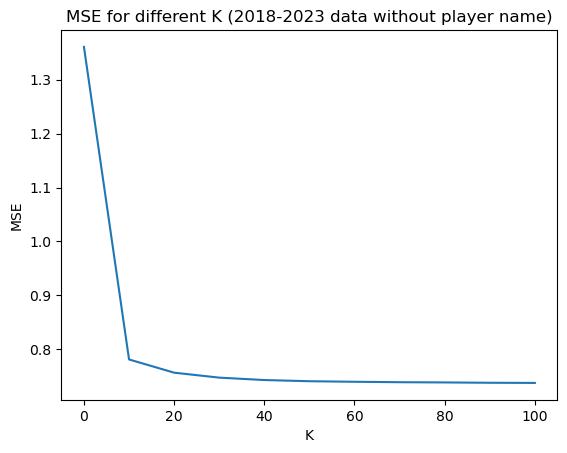

In [115]:
plt.plot(range(0,101,10), mse_lag_all)
plt.rcParams.update(plt.rcParamsDefault)
plt.title("MSE for different K (2018-2023 data without player name)")
plt.xlabel("K")
plt.ylabel("MSE")
plt.savefig('MSE_player_names_not_included.png')
plt.show()

In [30]:
# instantiate model
clf_optimal = KNeighborsRegressor(n_neighbors = 100)

# fit to training data
clf_optimal.fit(x_train_2018_22, y_train_2018_22)

# predict on test data
y_test_pred = clf_optimal.predict(x_test_2022_23)

# Calculate Test MSE & MAE
mse_test = mean_squared_error(y_test_2022_23, y_test_pred)
mae_test = mean_absolute_error(y_test_2022_23, y_test_pred)

print(f'Test MSE: %.3f' % mse_test)
print(f'Test MAE: %.3f' % mae_test)

Test MSE: 3.959
Test MAE: 1.049


In [132]:
x_test_2022_23 = x_test_2022_23.reset_index().drop(columns=['index'])
y_test_2022_23 = y_test_2022_23.reset_index().drop(columns=['index'])

filter_col = [col for col in x_test_2022_23 if col.startswith('player_team_name')]
team_indexes = {}
for i, col in enumerate(filter_col):
    team_indexes.update({col:x_test_2022_23.index[x_test_2022_23[col] == 1].tolist()})

In [133]:
# Calculate and store MSE and MAE for all players in test
mse_dict = {}
mae_dict = {}
position = {}
avg_pred = {}
avg_points = {}

for name, indexes in team_indexes.items():
    if indexes:
        mse = mean_squared_error(y_test_2022_23.iloc[indexes], y_test_pred[indexes])
        mae = mean_absolute_error(y_test_2022_23.iloc[indexes], y_test_pred[indexes])
        mse_dict.update({name:mse})
        mae_dict.update({name:mae})
        avg_pred.update({name:np.average(y_test_pred[indexes])})
        avg_points.update({name:np.average(y_test_2022_23.iloc[indexes])})

# Convert dictionaries to dataframes
df1 = pd.DataFrame(list(mse_dict.items()), columns=['name', 'mse'])
df2 = pd.DataFrame(list(mae_dict.items()), columns=['name', 'mae'])
df3 = pd.DataFrame(list(avg_pred.items()), columns=['name', 'avg_pred'])
df4 = pd.DataFrame(list(avg_points.items()), columns=['name', 'avg_points'])

# Merge the two dataframes on the 'name' column
total_team_pred_evals = pd.merge(df1, df2, on='name')
total_team_pred_evals_with_avg = pd.merge(total_team_pred_evals, df3, on='name')
total_team_pred_evals_with_avgs = pd.merge(total_team_pred_evals_with_avg, df4, on='name') 

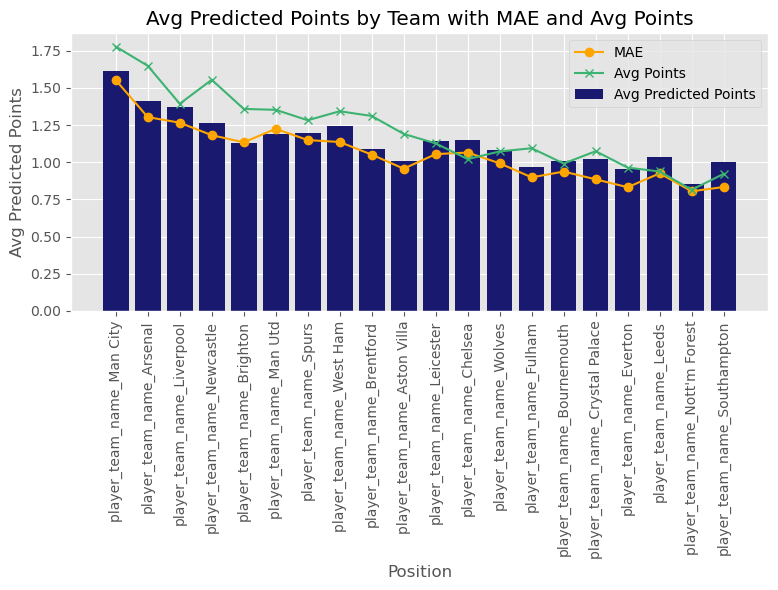

In [129]:
# Sort by mse and select the top 15 players
team_by_mse = total_team_pred_evals_with_avgs.sort_values(by='mse', ascending=False)

import matplotlib.style as style
style.use('ggplot')

# Plot 1: Avg Predicted Points by Team with MAE and Avg Points
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(team_by_mse['name'], pos_by_mse['avg_pred'], color='midnightblue')
plt.plot(team_by_mse['name'], pos_by_mse['mae'], color='orange', marker='o')
plt.plot(team_by_mse['name'], pos_by_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Position')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Team with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])
plt.tight_layout()
plt.savefig('chart_no_names.png')
plt.show()

In [135]:
filter_col = [col for col in x_test_2022_23 if col.startswith('position')]
team_indexes = {}
for i, col in enumerate(filter_col):
    team_indexes.update({col:x_test_2022_23.index[x_test_2022_23[col] == 1].tolist()})

# Calculate and store MSE and MAE for all players in test
mse_dict = {}
mae_dict = {}
position = {}
avg_pred = {}
avg_points = {}

for name, indexes in team_indexes.items():
    if indexes:
        mse = mean_squared_error(y_test_2022_23.iloc[indexes], y_test_pred[indexes])
        mae = mean_absolute_error(y_test_2022_23.iloc[indexes], y_test_pred[indexes])
        mse_dict.update({name:mse})
        mae_dict.update({name:mae})
        avg_pred.update({name:np.average(y_test_pred[indexes])})
        avg_points.update({name:np.average(y_test_2022_23.iloc[indexes])})

# Convert dictionaries to dataframes
df1 = pd.DataFrame(list(mse_dict.items()), columns=['name', 'mse'])
df2 = pd.DataFrame(list(mae_dict.items()), columns=['name', 'mae'])
df3 = pd.DataFrame(list(avg_pred.items()), columns=['name', 'avg_pred'])
df4 = pd.DataFrame(list(avg_points.items()), columns=['name', 'avg_points'])

# Merge the two dataframes on the 'name' column
total_team_pred_evals = pd.merge(df1, df2, on='name')
total_team_pred_evals_with_avg = pd.merge(total_team_pred_evals, df3, on='name')
total_team_pred_evals_with_avgs = pd.merge(total_team_pred_evals_with_avg, df4, on='name') 

pos_by_mse = total_team_pred_evals_with_avgs.sort_values(by='mse', ascending=False)

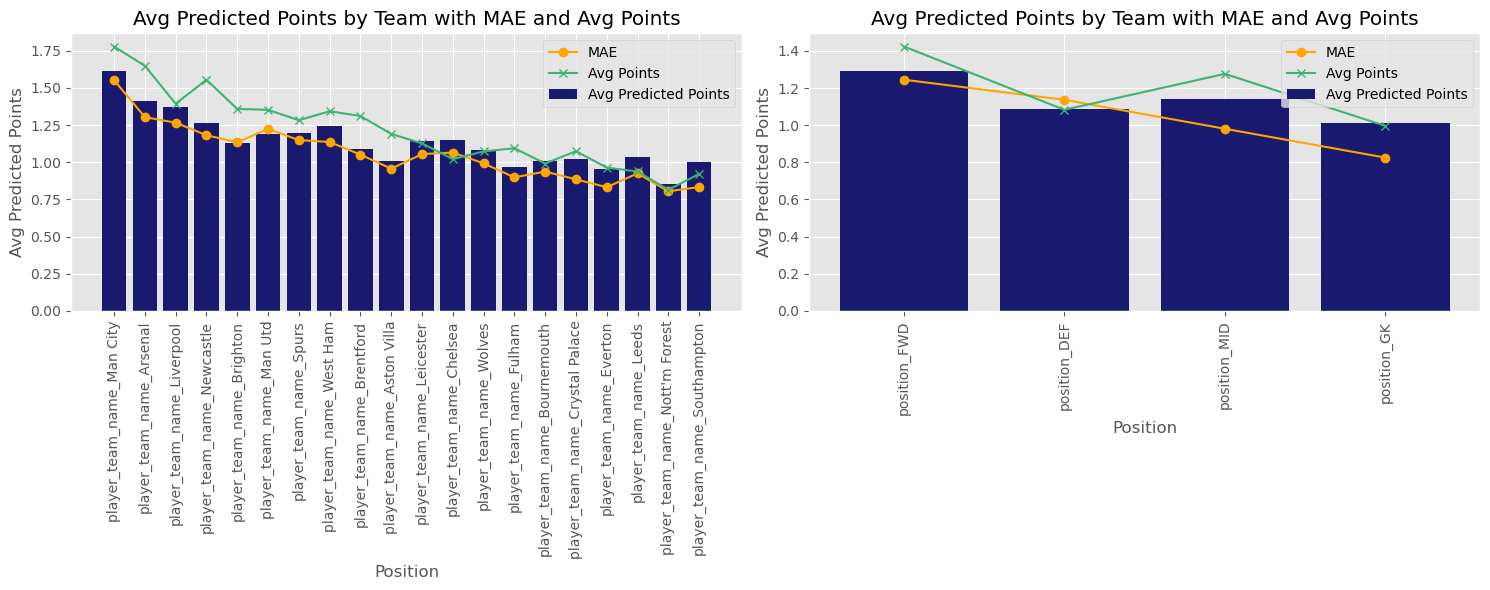

In [139]:
# Plot 1: MAE by team
plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
plt.bar(team_by_mse['name'], team_by_mse['avg_pred'], color='midnightblue')
plt.plot(team_by_mse['name'], team_by_mse['mae'], color='orange', marker='o')
plt.plot(team_by_mse['name'], team_by_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Position')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Team with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

# Plot 2: MAE by position
plt.subplot(1, 2, 2)
plt.bar(pos_by_mse['name'], pos_by_mse['avg_pred'], color='midnightblue')
plt.plot(pos_by_mse['name'], pos_by_mse['mae'], color='orange', marker='o')
plt.plot(pos_by_mse['name'], pos_by_mse['avg_points'], color='mediumseagreen', marker='x')
plt.xlabel('Position')
plt.ylabel('Avg Predicted Points')
plt.title('Avg Predicted Points by Team with MAE and Avg Points')
plt.xticks(rotation=90)
plt.legend(['MAE', 'Avg Points','Avg Predicted Points'])

plt.tight_layout()
plt.savefig('chart_no_names.png')
plt.show()

### read in data for 2016-2021 data

In [23]:
# get index for 2016-20 train, 2020-21 test split
x_2016_2020_index = x.index[x['season'].isin(['2016-17','2017-18','2018-19','2019-20'])].tolist()
x_2020_2021_index = x.index[x['season'].isin(['2020-21'])].tolist()

# get data for 2018-21 train, 2021-22 val, 2022-23 test split
x_train_2016_2020 = x_encoded.iloc[x_2016_2020_index]
x_test_2020_2021 = x_encoded.iloc[x_2020_2021_index]
y_train_2016_2020 = y.iloc[x_2016_2020_index].drop(columns=['season'])
y_test_2020_2021 = y.iloc[x_2020_2021_index].drop(columns=['season'])

x_train_lag1_2 = x_train_2016_2020[lag1_features]
x_train_lag3_2 = x_train_2016_2020[lag3_features]
x_train_lag5_2 = x_train_2016_2020[lag5_features]

x_test_lag1_2 = x_test_2020_2021[lag1_features]
x_test_lag3_2 = x_test_2020_2021[lag3_features]
x_test_lag5_2 = x_test_2020_2021[lag5_features]

In [27]:
# run for lag 1 data
print("2016-2021 data")
print("\nlag 1 results: ")
mse_lag1_2 = run_knn(21, x_train_lag1_2, x_test_lag1_2, y_train_2016_2020, y_test_2020_2021)

print("\nlag 3 results: ")
mse_lag2_2 = run_knn(21, x_train_lag3_2, x_test_lag3_2, y_train_2016_2020, y_test_2020_2021)

# run for lag 5 data
print("\nlag 5 results: ")
mse_lag3_2 = run_knn(21, x_train_lag5_2, x_test_lag5_2, y_train_2016_2020, y_test_2020_2021)

# run for all data
print("\nall lag results: ")
mse_lag_all_2 = run_knn(21, x_train_2016_2020, x_test_2020_2021, y_train_2016_2020, y_test_2020_2021)

2016-2021 data

lag 1 results: 
Optimal K:  20
MSE Error:  4.70161625282167
MAE Error:  1.2471331828442438

lag 3 results: 
Optimal K:  20
MSE Error:  4.682300430946029
MAE Error:  1.2167781654011904

lag 5 results: 
Optimal K:  20
MSE Error:  4.732001128668171
MAE Error:  1.2252554894315617

all lag results: 
Optimal K:  20
MSE Error:  4.637073466037349
MAE Error:  1.194340242150626
